<a href="https://colab.research.google.com/github/AnovaYoung/whatsmyshape/blob/main/Malaria_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The Problem**: Malaria is a contagious disease caused by Plasmodium parasites that are transmitted to humans through the bites of infected female Anopheles mosquitoes.The parasites enter the blood and begin damaging red blood cells(RBCs)that carry oxygen,which can result in respiratory distress and other complications.
Traditional diagnosis of malaria in the laboratory requires careful inspection by an experienced professional to discriminate between healthy and infected red blood cells. It is a tedious, time-consuming process,and the diagnostic accuracy(which heavily depends on human expertise) can be adversely impacted by inter-observer variability.Anautomated system can help with the early and accurate detection of malaria.

**Objective**: Build an efficient computer vision model to detect malaria.The model should identify whether the image of a red blood cell is that of one infected with malaria or not,and classify the same as parasitized or uninfected, respectively

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

np.random.seed(0)

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

print("All libraries imported")

All libraries imported


In [7]:
import zipfile

zip_ref = zipfile.ZipFile("/content/cell_images.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

Organize the images in 4D numpy arrays and create labels.

In [8]:
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img

#path to our directories
train_data_dir = '/tmp/cell_images/train'
test_data_dir = '/tmp/cell_images/test'

img_width, img_height = 64, 64
#initialize the images
def preprocess_data(data_dir, num_samples):
  X = np.zeros((num_samples, img_width, img_height, 3))
  y = np.zeros((num_samples,))

  for label, class_name in enumerate(['Uninfected', 'Parasitized']):
    print(f'Processing {class_name} images...')
    dir_path = os.path.join(data_dir, class_name)
    class_images = os.listdir(dir_path)

    #enumerate over the images
    for i, image_name in enumerate(class_images):
      img = load_img(os.path.join(dir_path, image_name), target_size=(img_width, img_height))
      X[i] = img_to_array(img)
      y[i] = label

      X/=255.0 #normalize array, pixel = 0-1

      return X,y



In [9]:
!ls /tmp


cell_images
dap_multiplexer.da5ef8f3decc.root.log.INFO.20230811-154322.89
dap_multiplexer.INFO
debugger_bzs3rbkqk
directoryprefetcher_binary.da5ef8f3decc.root.log.INFO.20230811-160025.4417
directoryprefetcher_binary.INFO
drive.da5ef8f3decc.root.log.ERROR.20230811-160023.4330
drive.da5ef8f3decc.root.log.INFO.20230811-160018.4242
drive.da5ef8f3decc.root.log.INFO.20230811-160019.4249
drive.da5ef8f3decc.root.log.INFO.20230811-160023.4242
drive.da5ef8f3decc.root.log.INFO.20230811-160023.4330
drive.da5ef8f3decc.root.log.WARNING.20230811-160023.4330
drive.ERROR
drivefs_ipc.0
drivefs_ipc.0_shell
drive.INFO
drive.WARNING
initgoogle_syslog_dir.0
language_service.da5ef8f3decc.root.log.INFO.20230811-155457.2922
language_service.INFO
pyright-2928-Hr5WgRkXYQMC
pyright-2928-yYyCy0nERT9W
python-languageserver-cancellation


Assigning values

In [10]:
!ls /tmp/cell_images/train
!ls /tmp/cell_images/test

parasitized  uninfected
parasitized  uninfected


In [11]:
train_data_dir = '/tmp/cell_images/train'
test_data_dir = '/tmp/cell_images/test'

parasitized_images = os.listdir(os.path.join(train_data_dir, 'parasitized'))
uninfected_images = os.listdir(os.path.join(train_data_dir, 'uninfected'))


Retrieving shape/info of test and train data

In [12]:

def print_dataset_info(data_dir):
    categories = ['parasitized', 'uninfected']
    for category in categories:
        num_images = len(os.listdir(os.path.join(data_dir, category)))
        print(f'Number of {category} images in {data_dir}: {num_images}')

print_dataset_info(train_data_dir)
print_dataset_info(test_data_dir)


Number of parasitized images in /tmp/cell_images/train: 12582
Number of uninfected images in /tmp/cell_images/train: 12376
Number of parasitized images in /tmp/cell_images/test: 1300
Number of uninfected images in /tmp/cell_images/test: 1300


We see roughly 200 more images in the *training* set of the 'parasitized' cells than the training set of the 'uninfected' cells.
subsequently, the aforementioned images for the *test* sets are equal at 1300.

Loading and Processing Training Data

In [13]:
import os
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array


train_images = []
train_labels = []

parasitized_dir = '/tmp/cell_images/train/parasitized'
uninfected_dir = '/tmp/cell_images/train/uninfected'

#infected images
for filename in os.listdir(parasitized_dir):
    try:
        image_path = os.path.join(parasitized_dir, filename)
        image = load_img(image_path, target_size=(64, 64))
        image = img_to_array(image)
        train_images.append(image)
        train_labels.append(1)  # Parasitized cells are labelled as 1
    except Exception as e:

        print(f'Error processing file {filename}: {e}')

        pass

# uninfected images
for filename in os.listdir(uninfected_dir):
    try:
        image_path = os.path.join(uninfected_dir, filename)
        image = load_img(image_path, target_size=(64, 64))
        image = img_to_array(image)
        train_images.append(image)
        train_labels.append(0)  # Uninfected cells are labelled as 0
    except Exception as e:
        print(f'Error processing file {filename}: {e}')
        pass

# Convert to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)


Loading and processing Test Data

In [14]:

test_images = []
test_labels = []


parasitized_dir = '/tmp/cell_images/test/parasitized'
uninfected_dir = '/tmp/cell_images/test/uninfected'


for filename in os.listdir(parasitized_dir):
    try:
        image_path = os.path.join(parasitized_dir, filename)
        image = load_img(image_path, target_size=(64, 64))
        image = img_to_array(image)
        test_images.append(image)
        test_labels.append(1)
    except Exception as e:
        print(f'Error processing file {filename}: {e}')
        pass

for filename in os.listdir(uninfected_dir):
    try:
        image_path = os.path.join(uninfected_dir, filename)
        image = load_img(image_path, target_size=(64, 64))
        image = img_to_array(image)
        test_images.append(image)
        test_labels.append(0)
    except Exception as e:
        print(f'Error processing file {filename}: {e}')
        pass

test_images = np.array(test_images)
test_labels = np.array(test_labels)


In [15]:
print(f'Shape of training data: {train_images.shape}')
print(f'Shape of training labels: {train_labels.shape}')


Shape of training data: (24958, 64, 64, 3)
Shape of training labels: (24958,)


In [16]:
print(f'Shape of test data: {test_images.shape}')
print(f'Shape of test labels: {test_labels.shape}')


Shape of test data: (2600, 64, 64, 3)
Shape of test labels: (2600,)


The shapes of the data indicate that the dataset has been correctly set up for input to a Convolutional Neural Network.

Understanding min and max pixel values

In [17]:
#Train images
print('Train images:')
print('Min pixel value:', train_images.min())
print('Max pixel value:', train_images.max())

# Test images
print('Test images:')
print('Min pixel value:', test_images.min())
print('Max pixel value:', test_images.max())


Train images:
Min pixel value: 0.0
Max pixel value: 255.0
Test images:
Min pixel value: 0.0
Max pixel value: 255.0


Sum of values in uninfected and parasitized

In [18]:
# training data
num_train_parasitized = np.sum(train_labels == 1)
num_train_uninfected = np.sum(train_labels == 0)

# test data
num_test_parasitized = np.sum(test_labels == 1)
num_test_uninfected = np.sum(test_labels == 0)

print(f'Training data: {num_train_parasitized} parasitized and {num_train_uninfected} uninfected')
print(f'Test data: {num_test_parasitized} parasitized and {num_test_uninfected} uninfected')


Training data: 12582 parasitized and 12376 uninfected
Test data: 1300 parasitized and 1300 uninfected


Normalize Images (Intensity value, range 0-1)

In [19]:
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0


Using a visualization technique can help more clearly define if data is balanced or unbalanced.

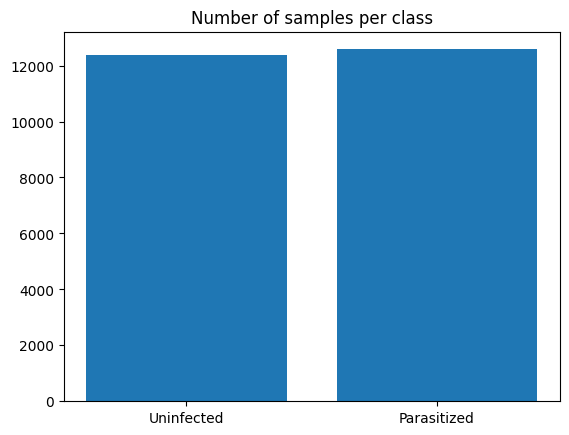

In [20]:
import matplotlib.pyplot as plt

classes, counts = np.unique(train_labels, return_counts=True)
# Create a bar plot
plt.bar(classes, counts, tick_label=['Uninfected', 'Parasitized'])
plt.title('Number of samples per class')

plt.show()

Seemingly very balanced data as the difference between the bars in minimal.

DATA EXPLORATION

Visualize Data from Train data.

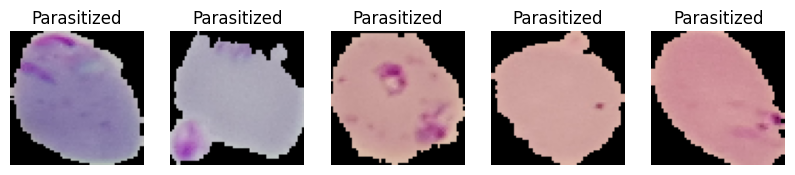

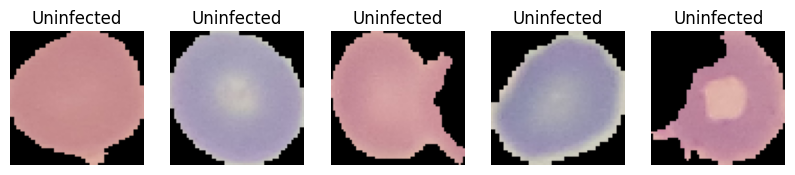

In [21]:
import matplotlib.pyplot as plt

#first few images of parasitized cells
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = train_images[train_labels == 1][i]
    plt.imshow(img)
    plt.title('Parasitized')
    plt.axis('off')
plt.show()

#first few images of uninfected cells
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = train_images[train_labels == 0][i]
    plt.imshow(img)
    plt.title('Uninfected')
    plt.axis('off')
plt.show()


In the parasitized cells discoloration can be observed in a purple hugh of slightly different shapes and sizes. The purple shapes are mostly circular. The uninfected images have no other shapes and colors inside them and are a smooth consistency in their coloring.

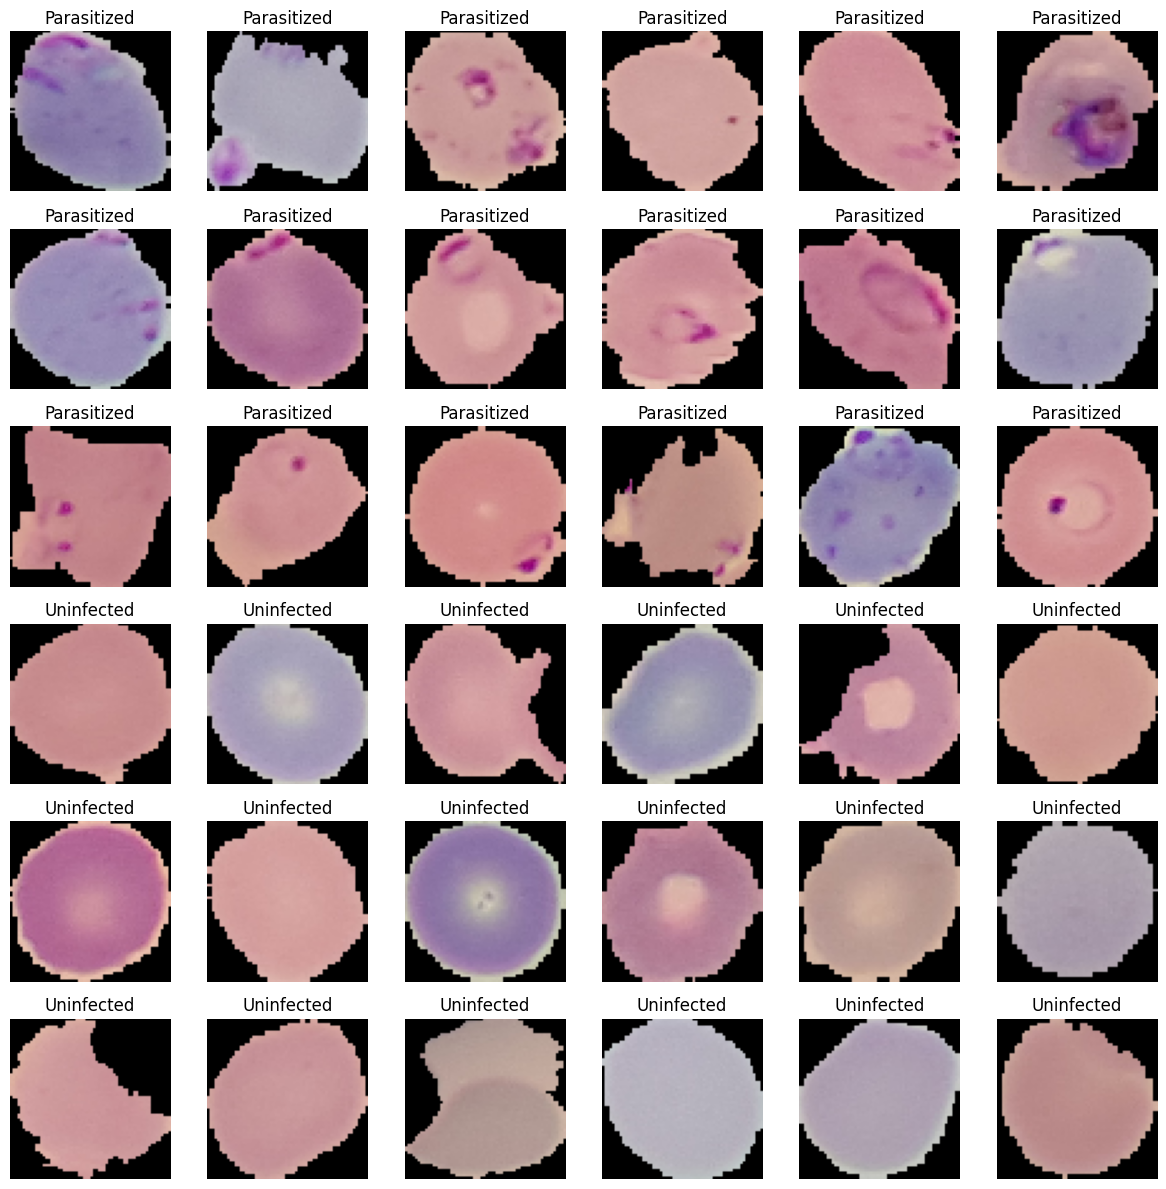

In [22]:
plt.figure(figsize=(12,12))

# Display 18 parasitized images
for i in range(18):
    plt.subplot(6,6,i+1)
    img = train_images[train_labels == 1][i]
    plt.imshow(img)
    plt.title('Parasitized')
    plt.axis('off')

# Display 18 uninfected images
for i in range(18,36):
    plt.subplot(6,6,i+1)
    img = train_images[train_labels == 0][i-18]
    plt.imshow(img)
    plt.title('Uninfected')
    plt.axis('off')

plt.tight_layout()#provides good/adequate spacing between the images

plt.show()


Plot mean images for parasitized and uninfected

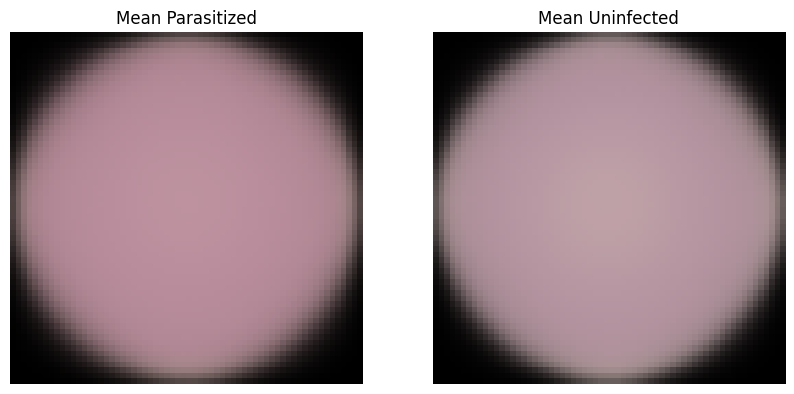

In [23]:
parasitized_images = train_images[train_labels == 1]
uninfected_images = train_images[train_labels == 0]

mean_parasitized = np.mean(parasitized_images, axis=0)
mean_uninfected = np.mean(uninfected_images, axis=0)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(mean_parasitized)
plt.title('Mean Parasitized')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(mean_uninfected)
plt.title('Mean Uninfected')
plt.axis('off')

plt.show()


We see general patterns and characteristics, such as circulatory images and the color pink. Parasitized's color is slightly darker pink then uninfected.

Converting RBG to HSV will seperate luminance information from chromatic information

In [24]:
import cv2
#training images
train_images_hsv = [cv2.cvtColor(image, cv2.COLOR_RGB2HSV) for image in train_images]
train_images_hsv = np.array(train_images_hsv)


In [25]:
#testing images
test_images_hsv = [cv2.cvtColor(image, cv2.COLOR_RGB2HSV) for image in test_images]
test_images_hsv = np.array(test_images_hsv)


Visualizing HSV is tricky most display methods expect RGB images. Each chanel in the HSV image represents different info (Hue, Saturation, and Value). It wont look like natural colors.

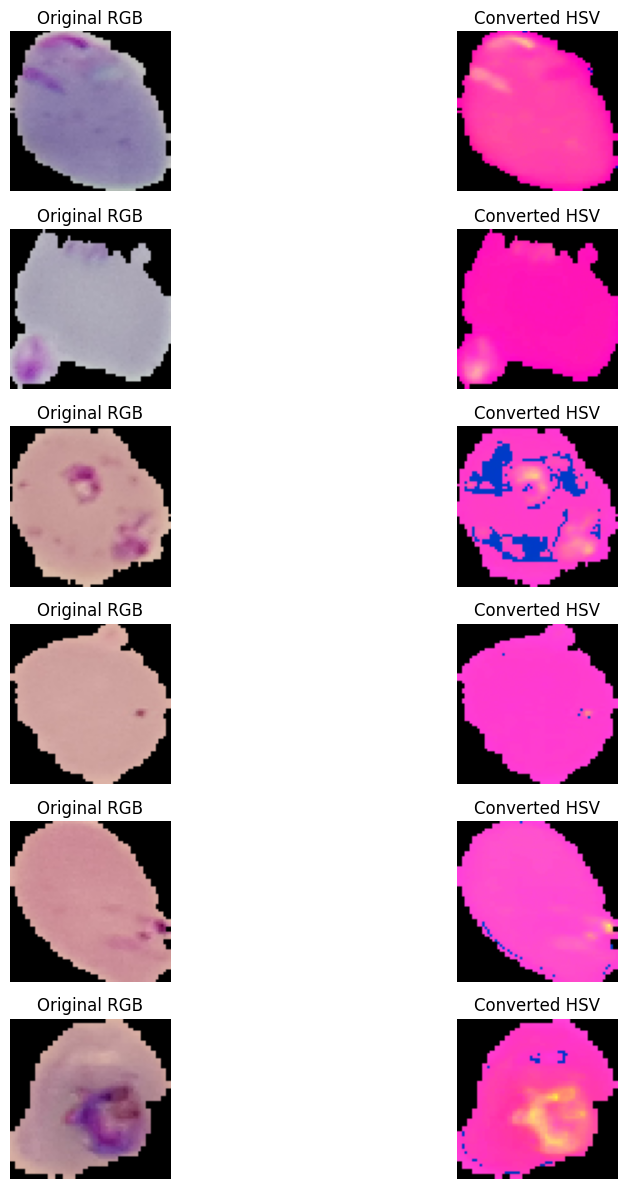

In [26]:
plt.figure(figsize=(12,12))

# Display first few original and HSV-converted images
for i in range(6):
    # Original RGB image
    plt.subplot(6,2,2*i+1)
    plt.imshow(train_images[i])
    plt.title('Original RGB')
    plt.axis('off')

    # Corresponding HSV image
    plt.subplot(6,2,2*i+2)
    img_hsv = cv2.cvtColor(train_images[i], cv2.COLOR_RGB2HSV)
    plt.imshow(img_hsv)
    plt.title('Converted HSV')
    plt.axis('off')

plt.tight_layout()
plt.show()


Moving on to processing images using Gaussian Blurring

In [27]:
#training images
train_images_blurred = [cv2.GaussianBlur(image, (5, 5), 0) for image in train_images]
train_images_blurred = np.array(train_images_blurred)

#testing images
test_images_blurred = [cv2.GaussianBlur(image, (5, 5), 0) for image in test_images]
test_images_blurred = np.array(test_images_blurred)


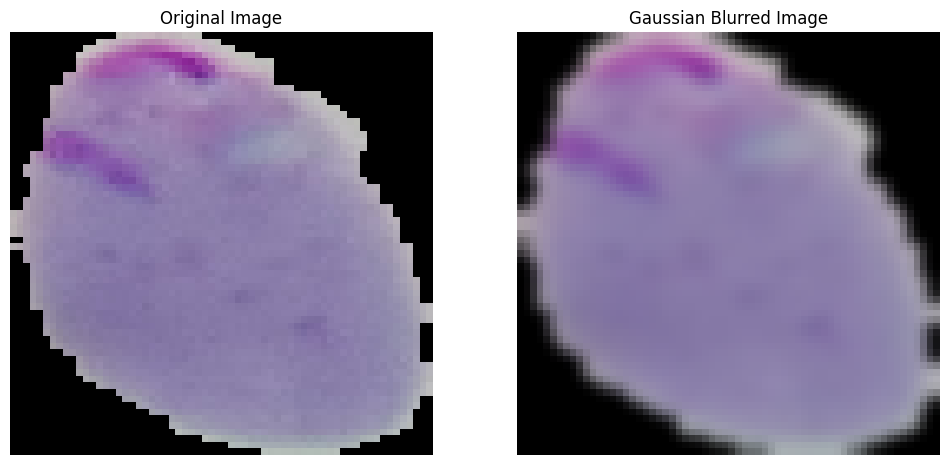

In [28]:
#Visualize the effects of Gaussian Bluring
plt.figure(figsize=(12,6))

# Original image
plt.subplot(1,2,1)
plt.imshow(train_images[0])
plt.title('Original Image')
plt.axis('off')

# Blurred image
plt.subplot(1,2,2)
plt.imshow(train_images_blurred[0])
plt.title('Gaussian Blurred Image')
plt.axis('off')

plt.show()


Blurred image has a reduction in fine details.

**MODEL BUILDING**

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical


One-hot encoding

In [30]:
#training labels
train_labels_onehot = to_categorical(train_labels, num_classes=2)
#test labels
test_labels_onehot = to_categorical(test_labels, num_classes=2)

One-hot encoding might seem a bit overkill since my labels are already binary, but it generalizes code and makes it more adaptable. It also aligns well with using categoriacal cross-entropy as a loss function, helpful in classification problems.

Build the model.

In [31]:
model = Sequential()
#32 filters, kernel size (3,3)
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))

#64 filters, kernel size (3,3)
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

#128 filters, kernel size (3,3)
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

#flatten to feed into dense layer
model.add(Flatten())

# Dense layer- 128 neurons
model.add(Dense(128, activation='relu'))

#prevent overfitting
model.add(Dropout(0.5))

# Output layer with 2 neurons (since there are 2 classes)
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

This model consists of three convolutional layers followed by max-pooling layers, a flattening layer to transform the 2D matrix data to a vector, a dense hidden layer, a dropout layer to prevent overfitting, and an output layer with two neurons and a softmax activation function.

Callbacks

In [65]:
#recoding this to make clear where the callback is coming from.
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Stop training when the validation loss metric has stopped decreasing for 3 epochs.
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Reduce learning rate when the validation loss metric has stopped decreasing for 2 epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

# Save the best model during training.
model_checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)

# Group callbacks into a list.
callbacks = [early_stopping, reduce_lr, model_checkpoint]

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_7 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 2)                 514       
                                                                 
Total params: 16,812,610
Trainable params: 2,097,922
Non-trainable params: 14,714,688
_________________________________________________________________


Now fit and train the model

In [33]:
history = model.fit(
    x=train_images,
    y=train_labels,
    validation_data=(test_images, test_labels),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/50
780/780 [==============================] - 104s 131ms/step - loss: 0.2598 - accuracy: 0.8795 - val_loss: 0.0920 - val_accuracy: 0.9662 - lr: 0.0010
Epoch 2/50
780/780 [==============================] - 102s 131ms/step - loss: 0.0766 - accuracy: 0.9757 - val_loss: 0.0949 - val_accuracy: 0.9677 - lr: 0.0010
Epoch 3/50
780/780 [==============================] - 103s 132ms/step - loss: 0.0663 - accuracy: 0.9787 - val_loss: 0.0396 - val_accuracy: 0.9854 - lr: 0.0010
Epoch 4/50
780/780 [==============================] - 102s 130ms/step - loss: 0.0586 - accuracy: 0.9801 - val_loss: 0.0398 - val_accuracy: 0.9865 - lr: 0.0010
Epoch 5/50
780/780 [==============================] - 101s 130ms/step - loss: 0.0543 - accuracy: 0.9811 - val_loss: 0.0380 - val_accuracy: 0.9858 - lr: 0.0010
Epoch 6/50
780/780 [==============================] - 103s 132ms/step - loss: 0.0507 - accuracy: 0.9820 - val_loss: 0.0442 - val_accuracy: 0.9869 - lr: 0.0010
Epoch 7/50
780/780 [==========================

**Observations:**
*This model will be called model B*. The model stopped running at epoch 8. The EarlyStopping call back's patience is set to 3 -- if the Validation Loss Metric fails to decrease further after 3 epochs it will halt the model. This is to attempt as low of a val_loss score as possible while building a high accuracy score. Benefiet of model stop is to avoid overfitting and save time. About
98% accuracy and about 4% loss. these numbers are hugely promising for a effective and accurate model.  

Plotting confusion matrix

82/82 [==============================] - 3s 34ms/step


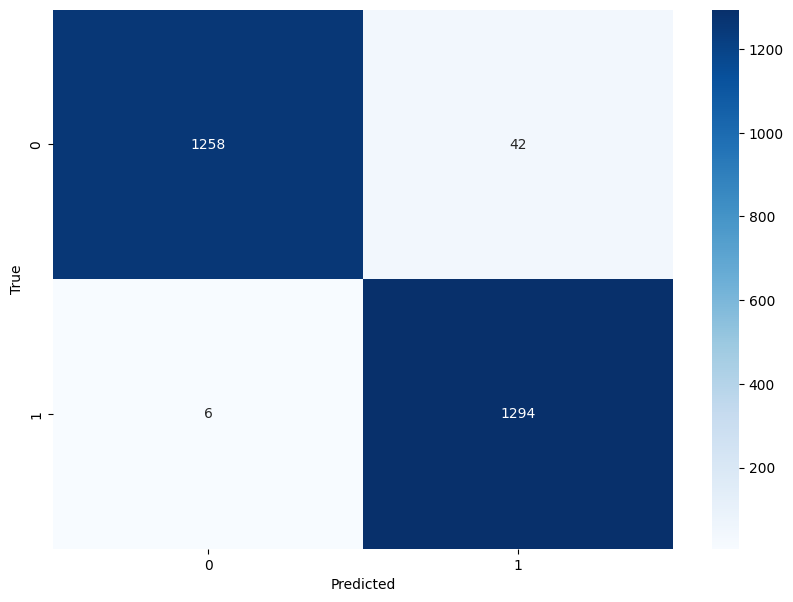

In [34]:
#re-importing libraries to demonstrate where the subsequent code gets pulled from
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

true_labels = test_labels
predicted_labels = model.predict(test_images)
predicted_labels = np.argmax(predicted_labels, axis=1)  # If your model outputs one-hot encoded predictions

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


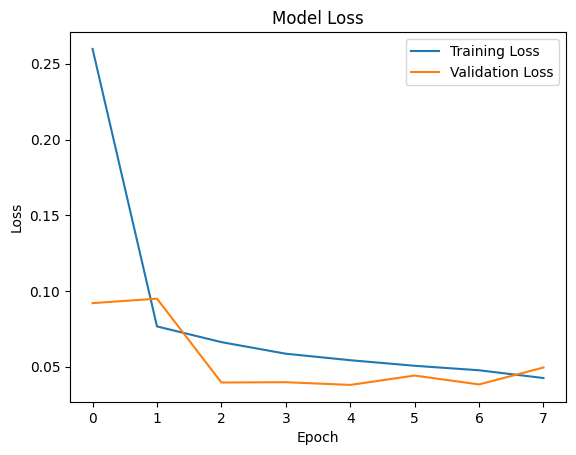

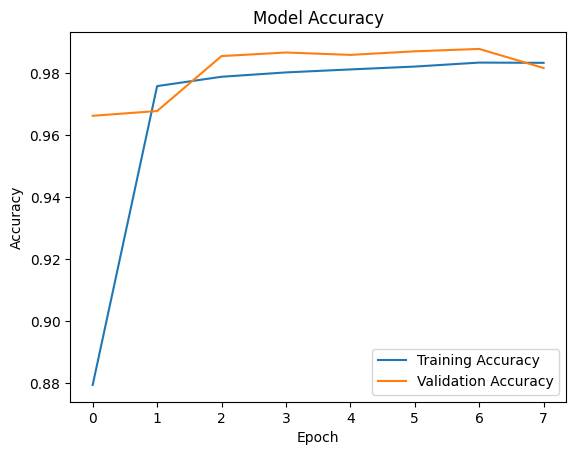

In [35]:

# training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


More advanced model. 3 covolutional blocks.

In [36]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()

# Convolutional Block 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Convolutional Block 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Convolutional Block 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # Assuming binary classification

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
This model consists of three convolutional layers followed by max-pooling layers, a flattening layer to transform the 2D matrix data to a vector, a dense hidden layer, a dropout layer to prevent overfitting, and an output layer with two neurons and a softmax activation function.

Callback

In [37]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

callbacks = [early_stopping, reduce_lr, model_checkpoint]


Fit and train the model

In [38]:
history = model.fit(
    x=train_images,
    y=train_labels,
    validation_data=(test_images, test_labels),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/50
780/780 [==============================] - 339s 431ms/step - loss: 0.3231 - accuracy: 0.8750 - val_loss: 0.1206 - val_accuracy: 0.9662 - lr: 0.0010
Epoch 2/50
780/780 [==============================] - 330s 423ms/step - loss: 0.1039 - accuracy: 0.9657 - val_loss: 0.0657 - val_accuracy: 0.9869 - lr: 0.0010
Epoch 3/50
780/780 [==============================] - 330s 423ms/step - loss: 0.0915 - accuracy: 0.9697 - val_loss: 0.0600 - val_accuracy: 0.9808 - lr: 0.0010
Epoch 4/50
780/780 [==============================] - 330s 423ms/step - loss: 0.0946 - accuracy: 0.9698 - val_loss: 0.0609 - val_accuracy: 0.9823 - lr: 0.0010
Epoch 5/50
780/780 [==============================] - 331s 424ms/step - loss: 0.0913 - accuracy: 0.9700 - val_loss: 0.0495 - val_accuracy: 0.9838 - lr: 0.0010
Epoch 6/50
780/780 [==============================] - 331s 424ms/step - loss: 0.0899 - accuracy: 0.9710 - val_loss: 0.0820 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 7/50
780/780 [==========================

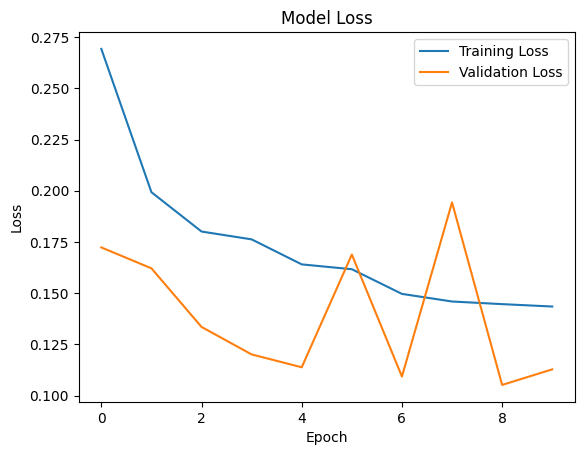

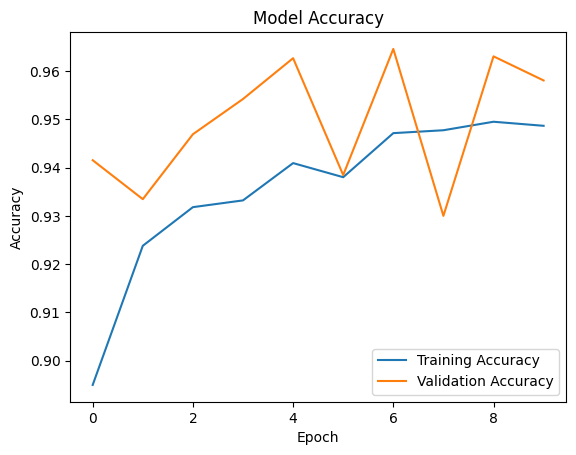

In [64]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

This is an example of how more complex models don't guarantee better results. This model does poorer at identifying between parasatized and uninfected cells than the one previously built.

Building a model between the complexities of the first and second models built.

In [66]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

image_height = 64
image_width = 64

model = Sequential()

# Input layer, first convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)))
model.add(MaxPooling2D((2, 2)))

# Second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

#connected layer
model.add(Dense(128, activation='relu'))

# reduce overfitting
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 6, 128)       

Callbacks

In [40]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
model_checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)

callbacks_list = [early_stopping, reduce_lr, model_checkpoint]


Fit and Train.

In [41]:
history = model.fit(
    train_images, train_labels,
    validation_data=(test_images, test_labels),
    epochs=50,
    batch_size=32,
    callbacks=callbacks_list
)


Epoch 1/50
780/780 [==============================] - 101s 128ms/step - loss: 0.2381 - accuracy: 0.8922 - val_loss: 0.0664 - val_accuracy: 0.9785 - lr: 0.0010
Epoch 2/50
780/780 [==============================] - 100s 128ms/step - loss: 0.0762 - accuracy: 0.9764 - val_loss: 0.0415 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 3/50
780/780 [==============================] - 99s 127ms/step - loss: 0.0662 - accuracy: 0.9798 - val_loss: 0.0423 - val_accuracy: 0.9885 - lr: 0.0010
Epoch 4/50
780/780 [==============================] - 100s 128ms/step - loss: 0.0592 - accuracy: 0.9799 - val_loss: 0.0372 - val_accuracy: 0.9862 - lr: 0.0010
Epoch 5/50
780/780 [==============================] - 99s 126ms/step - loss: 0.0576 - accuracy: 0.9811 - val_loss: 0.0382 - val_accuracy: 0.9877 - lr: 0.0010
Epoch 6/50
780/780 [==============================] - 100s 129ms/step - loss: 0.0529 - accuracy: 0.9817 - val_loss: 0.0356 - val_accuracy: 0.9881 - lr: 0.0010
Epoch 7/50
780/780 [============================

val_loss is aprox. 3.3% greater that training loss. val_accuracy is aprox. .6% less than training accuracy.

Visualizing this model.

82/82 [==============================] - 3s 34ms/step


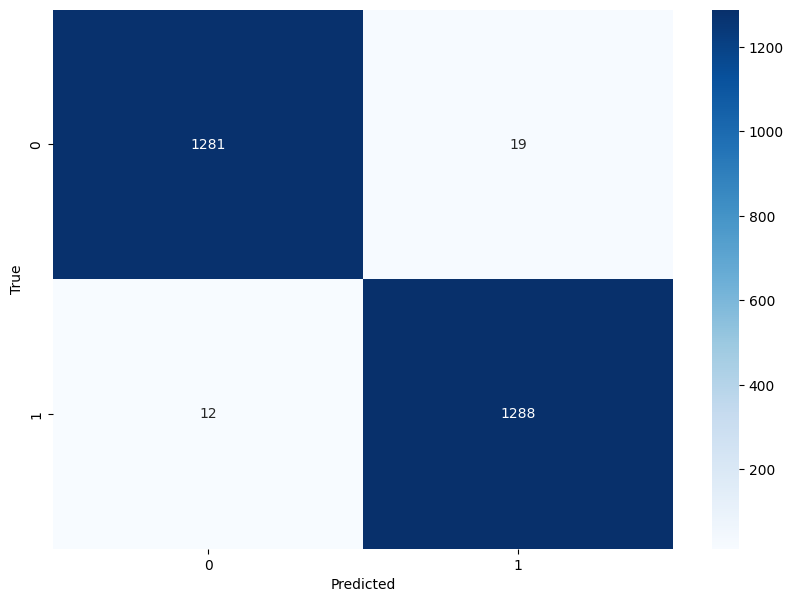

In [42]:
true_labels = test_labels
predicted_labels = model.predict(test_images)
predicted_labels = np.argmax(predicted_labels, axis=1)  # If your model outputs one-hot encoded predictions

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

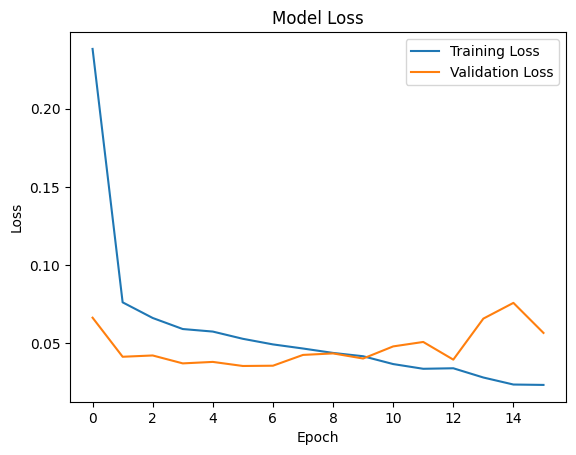

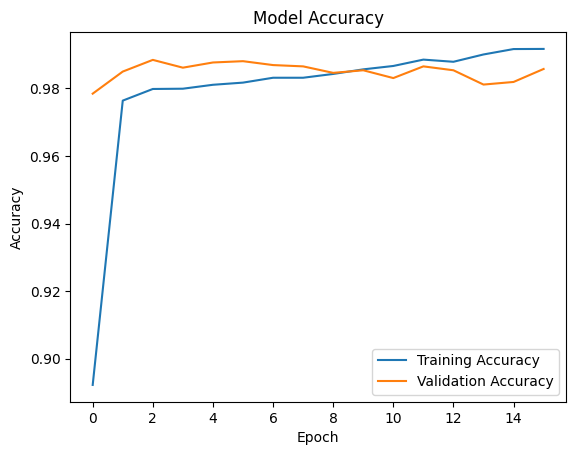

In [43]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

*This model will be called model C*. model C seems to be understanding the training data well but not generalizing to unseen data well at all.

**Data Augmentation**

In [44]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False)

Visualize

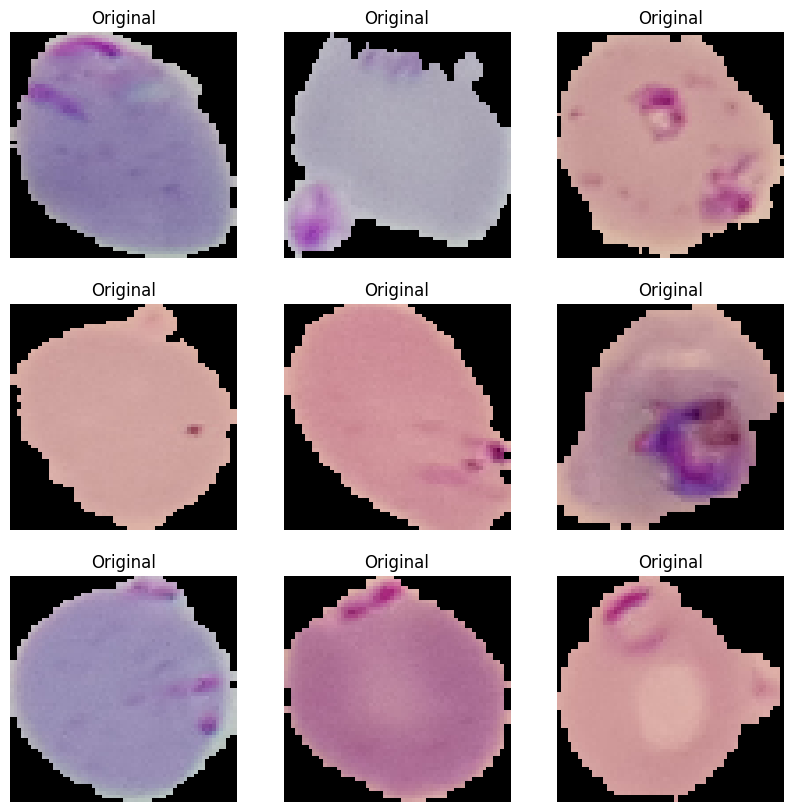

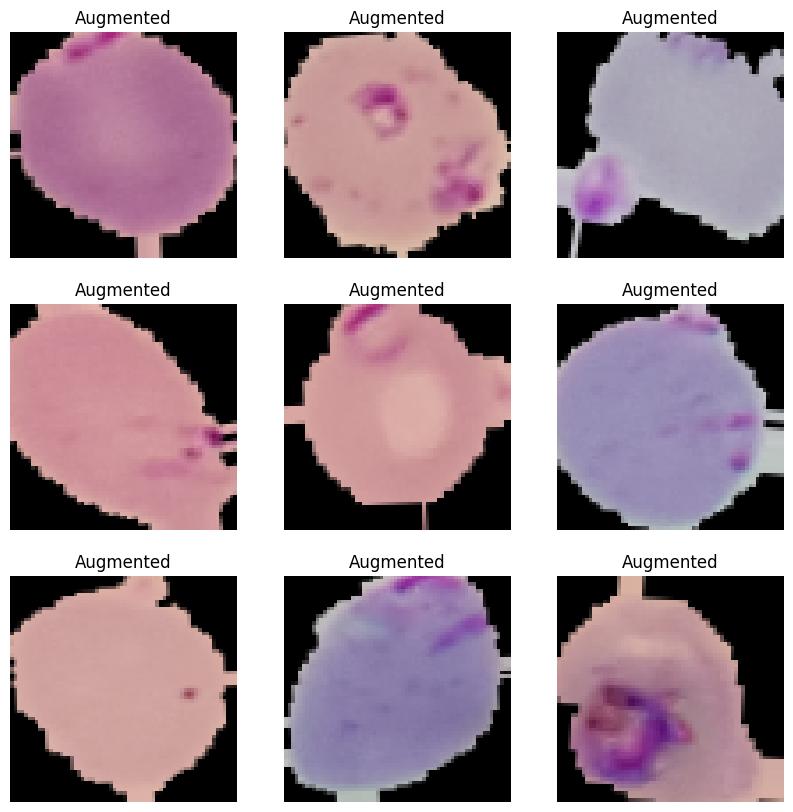

In [45]:
import matplotlib.pyplot as plt

example_images = train_images[:9]

augmented_images = next(datagen.flow(example_images, batch_size=9))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(example_images[i])
    plt.title("Original")
    plt.axis("off")

plt.show()
#augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.title("Augmented")
    plt.axis("off")

plt.show()


In [46]:
datagen.fit(train_images)


In [47]:
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    validation_data=(test_images, test_labels),
    epochs=50,
    steps_per_epoch=len(train_images) // 32,
    callbacks=callbacks)


Epoch 1/50
779/779 [==============================] - 115s 147ms/step - loss: 0.0861 - accuracy: 0.9725 - val_loss: 0.0452 - val_accuracy: 0.9858 - lr: 0.0010
Epoch 2/50
779/779 [==============================] - 119s 152ms/step - loss: 0.0771 - accuracy: 0.9743 - val_loss: 0.0389 - val_accuracy: 0.9846 - lr: 0.0010
Epoch 3/50
779/779 [==============================] - 130s 166ms/step - loss: 0.0726 - accuracy: 0.9758 - val_loss: 0.0445 - val_accuracy: 0.9838 - lr: 0.0010
Epoch 4/50
779/779 [==============================] - 115s 148ms/step - loss: 0.0719 - accuracy: 0.9763 - val_loss: 0.0411 - val_accuracy: 0.9873 - lr: 0.0010
Epoch 5/50
779/779 [==============================] - 114s 146ms/step - loss: 0.0704 - accuracy: 0.9771 - val_loss: 0.0429 - val_accuracy: 0.9869 - lr: 0.0010
Epoch 6/50
779/779 [==============================] - 114s 147ms/step - loss: 0.0674 - accuracy: 0.9765 - val_loss: 0.0496 - val_accuracy: 0.9846 - lr: 0.0010
Epoch 7/50
779/779 [==========================

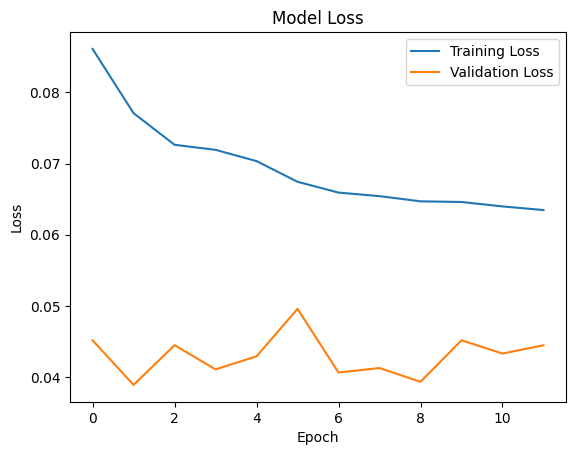

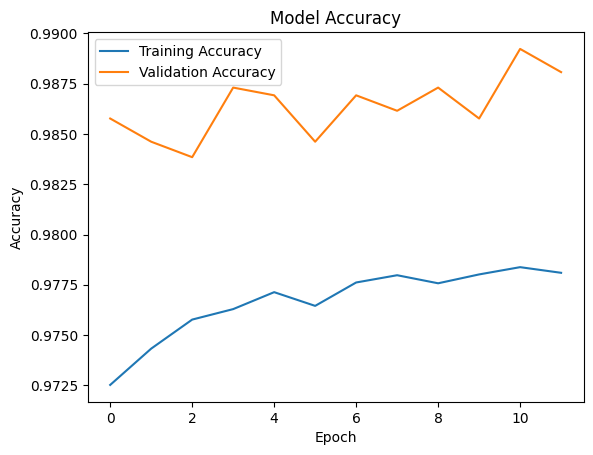

In [48]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

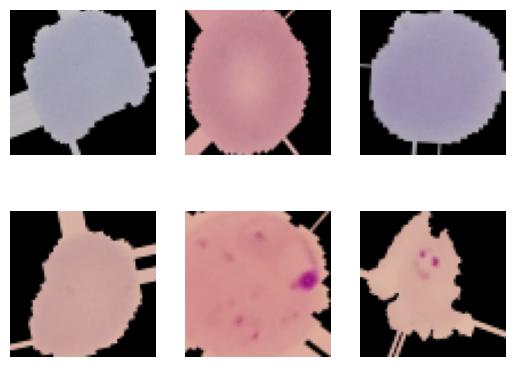

In [49]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2
)

datagen.fit(train_images)

augmented_images, _ = next(datagen.flow(train_images, train_labels, batch_size=6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(augmented_images[i])
    plt.axis('off')

plt.show()


In [50]:
datagen.fit(train_images)



In [51]:
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    validation_data=(test_images, test_labels),
    epochs=50,
    steps_per_epoch=len(train_images) // 32,
    callbacks=callbacks)

Epoch 1/50
779/779 [==============================] - 113s 145ms/step - loss: 0.1100 - accuracy: 0.9644 - val_loss: 0.0533 - val_accuracy: 0.9838 - lr: 0.0010
Epoch 2/50
779/779 [==============================] - 114s 146ms/step - loss: 0.0996 - accuracy: 0.9674 - val_loss: 0.0361 - val_accuracy: 0.9869 - lr: 0.0010
Epoch 3/50
779/779 [==============================] - 114s 147ms/step - loss: 0.0955 - accuracy: 0.9682 - val_loss: 0.0549 - val_accuracy: 0.9846 - lr: 0.0010
Epoch 4/50
779/779 [==============================] - 117s 150ms/step - loss: 0.0961 - accuracy: 0.9689 - val_loss: 0.0454 - val_accuracy: 0.9865 - lr: 0.0010
Epoch 5/50
779/779 [==============================] - 115s 147ms/step - loss: 0.0929 - accuracy: 0.9704 - val_loss: 0.0529 - val_accuracy: 0.9846 - lr: 0.0010
Epoch 6/50
779/779 [==============================] - 114s 146ms/step - loss: 0.0935 - accuracy: 0.9684 - val_loss: 0.0386 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 7/50
779/779 [==========================

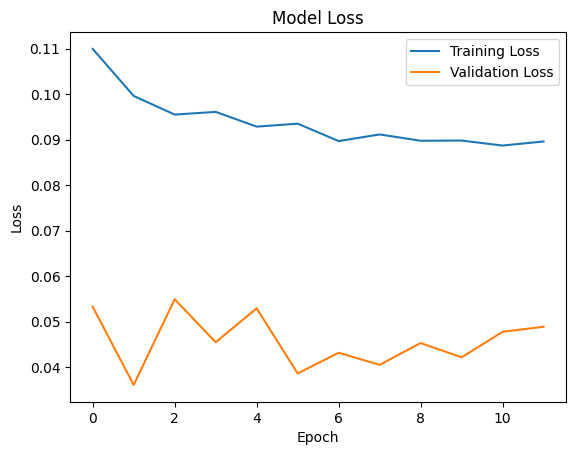

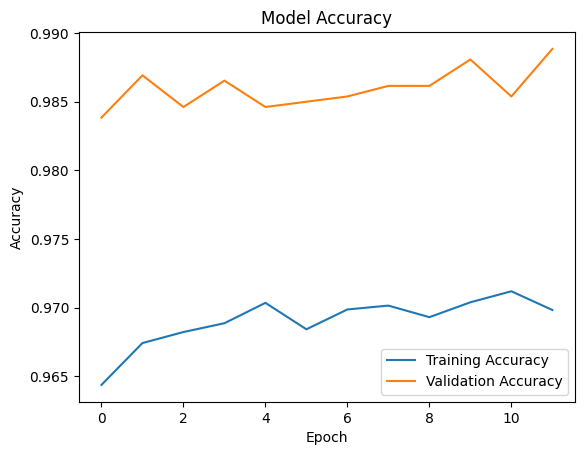

In [52]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Data Agumentation, with the given boundaries, is showing to be of little help to the model.

Importing VGG16 pre-trained model, adding fully connected layers.

In [53]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

# Import the VGG16 model, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
# Make the base_model non-trainable. we don't want to retrain these layers
for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential()

model.add(base_model) # Add the base model to the model

model.add(layers.Flatten())

# Add fully connected layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 [==============================] - 0s 0us/step


Callbacks

In [54]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=0.0001)
model_checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

callbacks_list = [early_stopping, reduce_lr, model_checkpoint]


In [57]:
from tensorflow.image import resize

# Resizing the train and test images
train_images_resized = resize(train_images, (128, 128))
test_images_resized = resize(test_images, (128, 128))

# Training the model with resized images
history = model.fit(train_images_resized, train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(test_images_resized, test_labels))


Epoch 1/10
780/780 [==============================] - 2664s 3s/step - loss: 0.2693 - accuracy: 0.8949 - val_loss: 0.1723 - val_accuracy: 0.9415
Epoch 2/10
780/780 [==============================] - 2631s 3s/step - loss: 0.1993 - accuracy: 0.9238 - val_loss: 0.1621 - val_accuracy: 0.9335
Epoch 3/10
780/780 [==============================] - 2642s 3s/step - loss: 0.1801 - accuracy: 0.9318 - val_loss: 0.1335 - val_accuracy: 0.9469
Epoch 4/10
780/780 [==============================] - 2633s 3s/step - loss: 0.1763 - accuracy: 0.9332 - val_loss: 0.1201 - val_accuracy: 0.9542
Epoch 5/10
780/780 [==============================] - 2642s 3s/step - loss: 0.1641 - accuracy: 0.9409 - val_loss: 0.1138 - val_accuracy: 0.9627
Epoch 6/10
780/780 [==============================] - 2620s 3s/step - loss: 0.1617 - accuracy: 0.9380 - val_loss: 0.1688 - val_accuracy: 0.9385
Epoch 7/10
780/780 [==============================] - 2653s 3s/step - loss: 0.1496 - accuracy: 0.9472 - val_loss: 0.1093 - val_accuracy:

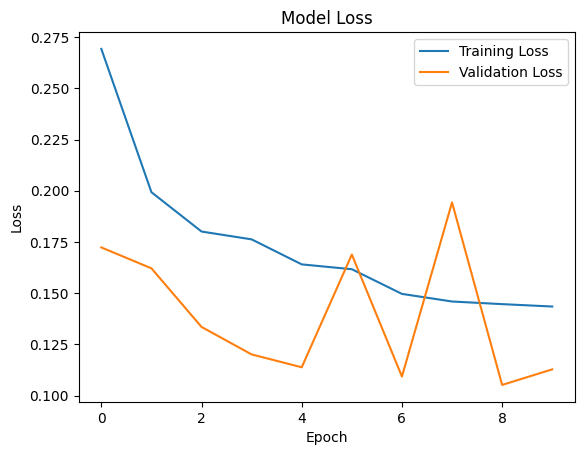

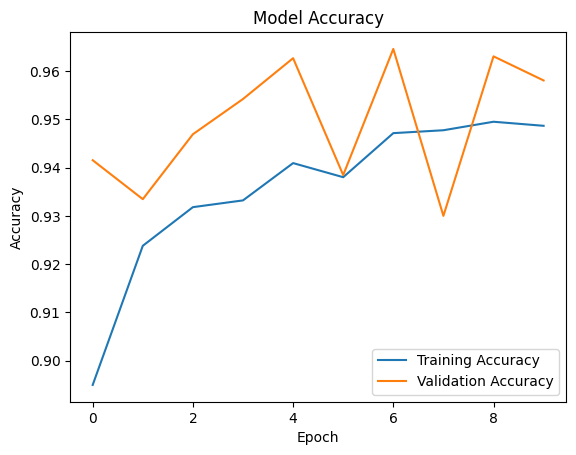

In [60]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

I will compare model B and model C from the findings above. Note, these were the only two models labeled.When comparing the two models, it's important to consider several factors, such as accuracy, loss, validation accuracy, validation loss, and possibly other context-specific considerations.

### Model B:

- Training Accuracy: 98.32%
- Validation Accuracy: 98.15%
- Training Loss: 4.26%
- Validation Loss: 4.95%

### Model C:

- Training Accuracy: 99.17%
- Validation Accuracy: 98.58%
- Training Loss: 2.35%
- Validation Loss: 5.67%

#### Analysis:

1. **Training Accuracy**: Model C has a higher training accuracy (99.17% compared to 98.32% in Model B), which indicates that it performs better on the data it was trained on.

2. **Validation Accuracy**: Model C also has a higher validation accuracy (98.58% compared to 98.15% in Model B), which suggests that it generalizes better to unseen data.

3. **Training Loss**: Model C has a lower training loss (2.35% compared to 4.26% in Model B), which indicates a better fit to the training data.

4. **Validation Loss**: Model C has a slightly higher validation loss (5.67% compared to 4.95% in Model B), which might indicate a small issue with overfitting, but the difference is not significant.

#### Conclusion:

Based on the provided metrics, Model C seems to be the better choice for malaria detection. It has both higher training and validation accuracy, and its training loss is lower. The slight increase in validation loss might need further investigation, but the overall performance seems to favor Model C.

However, these conclusions are based on the models shown above and their limitations. Going further into malaria detection other considerations will come into play, such as interpretability, computational efficiency, robustness to different kinds of data, etc. A more comprehensive evaluation will include additional steps like conducting more confusion matrix inspections, analyzing errors more thoroughly, and potentially conducting further experiments with different kinds of robust validation. But based solely on the given models, Model C seems to be the preferable choice.